In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import survivalstan as ss

# simulate data for model

## Set hyper-parameter values

For each subject, generate:

1. vector of random effects, from multivariate normal: (0, B)
2. vector of time-independent binary variables X1 and X2, from bernoulli dist with p=0.5
3. value of measurement error from normal dist, with mean=0 & sigma=1.25
4. vector of visit times: exponential dist with r0(t) = 2
5. 

For the simulation of biomarker (longitudinal data), set:

1. intercept (B0): `3.0`
2. slope over time (B1): `0.5`
3. coefficient for X1 (B2): `0.5`

For the simulation of recurrent events, set:

1. coefficient for X1 (B3): `0.5`
2. 

For the simulation of terminal events, set:

1. Coefficient for X2 (B4): `0.1`
2. Baseline hazard lambda0(t): `1.5`

Censor observations at Ci = `5.5`

In [2]:
## B1 matrix; defines distribution of random effects b0 and b1
sigma_00 = 1.5
sigma_01 = -0.5
sigma_10 = -0.5
sigma_11 = 0.8
sigma_v = 0.8

B1_matrix = np.matrix([[np.power(sigma_00, 2), sigma_01],
                      [sigma_10, np.power(sigma_11, 2)]])
B1_matrix

matrix([[ 2.25, -0.5 ],
        [-0.5 ,  0.64]])

In [3]:
## B matrix; includes subject-level parameters B1 and vi
B_matrix = np.zeros(shape=(3,3))
B_matrix[0:2, 0:2] = B1_matrix
B_matrix[2, 2] = np.power(sigma_v, 2)
B_matrix

array([[ 2.25, -0.5 ,  0.  ],
       [-0.5 ,  0.64,  0.  ],
       [ 0.  ,  0.  ,  0.64]])

In [4]:
## inputs to simulation - parameters & hard-coded values
N = 400
lambda_t_0 = 1.5
lambda_r_0 = 2.0
alpha = 2.6
B_t = np.matrix([0.1])
B_r = np.matrix([0.5])
B_l = np.matrix([3., 0.5, 0.5]).transpose()
eta_t = np.matrix([0.5, 0.5]).transpose()
eta_r = np.matrix([0.2, 0.2]).transpose()
censor = 5.5
meas_gap = 0.2

## Simulate parameter values for each subject

In [5]:
## simulate subject-level parameters for random effects
raneff = np.matrix(np.random.multivariate_normal(mean=(0,0,0), cov=B_matrix, size=N))
b = raneff[:,0:2]
vi = raneff[:,2]

## measurement error for longitudinal data simulation
def meas_error(n=1):
    return(np.random.normal(loc=0, scale=1.25, size=n))

## simulate covariate values
X = np.matrix(np.random.binomial(size=(N, 2), p=0.5, n=1))
X_l = X[:,0:1] # covariate X for longitudinal submodel
X_r = X[:,0:1] # covariate X for recurrent events submodel
X_t = X[:,1:2] # covariate X for terminal event submodel

In [30]:
def simulate_inputs(N,
                    B_matrix=None,
                    p=0.5,
                    sigma_00=1.5,
                    sigma_01=-0.5,
                    sigma_10=-0.5,
                    sigma_11=0.8,
                    sigma_v=0.8,
                    meas_error_scale=1.25,
                    **kwargs):

    ## construct B_matrix if not provided
    if not B_matrix:
        B1_matrix = np.matrix([[np.power(sigma_00, 2), sigma_01],
                              [sigma_10, np.power(sigma_11, 2)]])
        B_matrix = np.zeros(shape=(3,3))
        B_matrix[0:2, 0:2] = B1_matrix
        B_matrix[2, 2] = np.power(sigma_v, 2)

    ## simulate subject-level parameters for random effects
    raneff = np.matrix(np.random.multivariate_normal(mean=(0,0,0), cov=B_matrix, size=N))
    b = raneff[:,0:2]
    vi = raneff[:,2]
    
    ## measurement error for longitudinal data simulation
    def meas_error(n=1):
        return(np.random.normal(loc=0, scale=meas_error_scale, size=n))

    ## simulate covariate values
    X = np.matrix(np.random.binomial(size=(N, 2), p=p, n=1))
    X_l = X[:,0:1] # covariate X for longitudinal submodel
    X_r = X[:,0:1] # covariate X for recurrent events submodel
    X_t = X[:,1:2] # covariate X for terminal event submodel
    
    params = {
        'X_l': X_l,
        'X_r': X_r,
        'X_t': X_t,
        'meas_error': meas_error,
        'vi': vi,
        'b': b,
        'N': N,
        'lambda_t_0': 1.5,
        'lambda_r_0': 2.0,
        'alpha': 2.6,
        'B_t': np.matrix([0.1]),
        'B_r': np.matrix([0.5]),
        'B_l': np.matrix([3., 0.5, 0.5]).transpose(),
        'eta_t': np.matrix([0.5, 0.5]).transpose(),
        'eta_r': np.matrix([0.2, 0.2]).transpose(),
        'censor': 5.5,
        'meas_gap': 0.2,
        }
    
    if dict(**kwargs):
        params.update(dict(**kwargs))
    return(params)


## Simulate data for terminating events 

In [31]:
t_df = pd.DataFrame(data=np.random.exponential(lambda_t_0*np.exp(alpha*vi + X_t*B_t + b*eta_t)),
                    columns=['death'])
t_df['event_status'] = t_df['death'].apply(lambda x: 1 if x <= censor else 0)
t_df['event_time'] = t_df['death'].apply(lambda x: x if x <= censor else censor)
t_df.reset_index(inplace=True)

Plot survival curve from simulated data

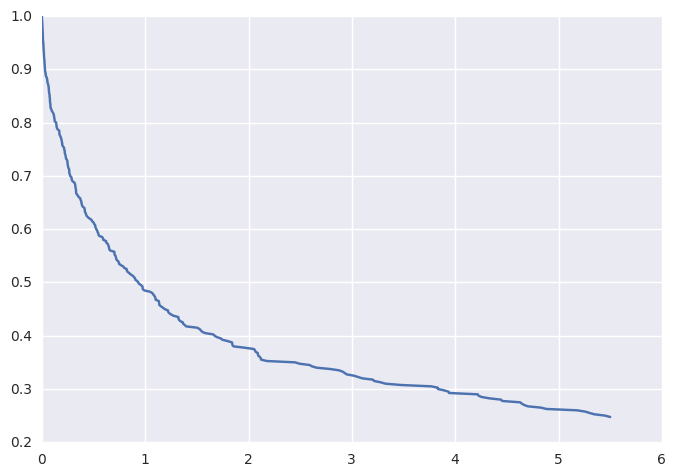

In [32]:
ss.utils.plot_observed_survival(df=t_df, event_col='event_status', time_col='event_time')

In [33]:
def simulate_terminal_events(lambda_t_0, alpha, vi, X_t, B_t, b, eta_t, censor, **kwargs):
    t_df = pd.DataFrame(data=np.random.exponential(lambda_t_0*np.exp(alpha*vi + X_t*B_t + b*eta_t)),
                        columns=['death'])
    t_df['event_status'] = t_df['death'].apply(lambda x: 1 if x <= censor else 0)
    t_df['event_time'] = t_df['death'].apply(lambda x: x if x <= censor else censor)
    t_df.reset_index(inplace=True)
    return(t_df)

## Simulate data for recurrent events

Simulate hypothetical "gap times" between first 6 recurrent events for each subject. Observed recurrent event times are cumsum of gap times. 

In [34]:
r_df = pd.DataFrame(data=np.random.exponential(lambda_r_0*np.exp(vi + X_r*B_r + b*eta_r), size=(N, 6)))
r_df = r_df.cumsum(axis=1)
r_df.reset_index(inplace=True)

Merge with terminating event data so that we can censored recurrent events which occurred after terminating event. Note that we don't care whether these terminating events are censor events or observed; either way the subject is censored.

In [35]:
r_df2 = pd.melt(r_df, id_vars='index', value_name='recurrence_time')
del r_df2['variable']
r_df2 = pd.merge(r_df2, t_df, on='index', how='outer')
r_df2.head()

,index,recurrence_time,death,event_status,event_time
0,0,0.009977,0.232592,1,0.232592
1,0,0.330892,0.232592,1,0.232592
2,0,1.111952,0.232592,1,0.232592
3,0,3.485308,0.232592,1,0.232592
4,0,3.872598,0.232592,1,0.232592


Here we remove events occurring after terminating event.

In [36]:
r_df3 = r_df2.query('recurrence_time <= event_time').copy()
r_df3.shape

(227, 5)

In [37]:
## clean up objects in memory
r_df = r_df3
del r_df2
del r_df3

Define a function for future use

In [38]:
def simulate_recurrent_events(lambda_r_0, vi, X_r, B_r, b, eta_r, N, t_df, max_events=6, **kwargs):
    r_df = pd.DataFrame(data=np.random.exponential(lambda_r_0*np.exp(vi + X_r*B_r + b*eta_r), size=(N, max_events)))
    r_df = r_df.cumsum(axis=1)
    r_df.reset_index(inplace=True)
    r_df2 = pd.melt(r_df, id_vars='index', value_name='recurrence_time')
    del r_df2['variable']
    r_df2 = pd.merge(r_df2, t_df, on='index', how='outer')
    r_df3 = r_df2.query('recurrence_time <= event_time').copy()
    return(r_df3)

## Simulate data for biomarker measurements

Finally we simulate data for biomarker measurements. 

We start by generating the observation times in intervals of `meas_gap`, with up to 20 observations per subject.

In [39]:
l_df = pd.DataFrame(np.ones(shape=(N, 20))*meas_gap)
l_df = l_df.cumsum(axis=1)
l_df.reset_index(inplace=True)
l_df2 = pd.melt(l_df, id_vars=['index'], value_name='biomarker_time')
del l_df2['variable']
l_df2.sort_values(['index','biomarker_time']).head()

,index,biomarker_time
0,0,0.2
400,0,0.4
800,0,0.6
1200,0,0.8
1600,0,1.0


Next we merge this with the terminating-event dataset so that we can exclude observations which would have occurred after the terminating event.

In [40]:
l_df3 = pd.merge(l_df2, t_df, on='index', how='outer')
l_df3 = l_df3.query('biomarker_time <= event_time').copy()

Finally, we simulate the biomarker values which would be observed at each timepoint, as a function of the subject-level parameters simulated above, the simulated covariate values & the time of observation.

In [41]:
def _sim_biomarker_values(row):
    index = int(row['index'])
    time = row['biomarker_time']
    X_x = np.matrix([1, time, X_l[index, 0]])
    b_x = b[index, :]
    x_x = np.matrix([1, time]).transpose()
    epsilon = meas_error()
    value = X_x*B_l + b_x*x_x + epsilon
    if len(value) != 1:
        print('Warning')
    else:
        return(float(value))
    

In [42]:
l_df3['biomarker_value'] = l_df3.apply(_sim_biomarker_values, axis=1)

In [43]:
l_df3.head()

,index,biomarker_time,death,event_status,event_time,biomarker_value
0,0,0.2,0.232592,1,0.232592,-0.466418
20,1,0.2,3.280094,1,3.280094,1.612260
21,1,0.4,3.280094,1,3.280094,2.144493
22,1,0.6,3.280094,1,3.280094,2.345802
23,1,0.8,3.280094,1,3.280094,4.406569


Finally, we left-censor these observations at a minimum observable value (here set to `-0.4`).

In [44]:
l_df4 = l_df3.copy()

l_df4['biomarker_value'] = l_df4['biomarker_value'].apply(lambda x: x if x>= -0.4 else -0.4)

In [45]:
l_df = l_df4
del l_df4
del l_df3
del l_df2

In [46]:
def simulate_longitudinal_biomarker(N, meas_gap, t_df, X_l, b, meas_error, B_l,
                                    left_censor_at=-0.4, max_visits=20, **kwargs):
    l_df = pd.DataFrame(np.ones(shape=(N, max_visits))*meas_gap)
    l_df = l_df.cumsum(axis=1)
    l_df.reset_index(inplace=True)
    l_df = pd.melt(l_df, id_vars=['index'], value_name='biomarker_time')
    del l_df['variable']
    
    l_df = pd.merge(l_df, t_df, on='index', how='outer')
    l_df = l_df.query('biomarker_time <= event_time').copy()
    
    def _sim_biomarker_values(row):
        index = int(row['index'])
        time = row['biomarker_time']
        X_x = np.matrix([1, time, X_l[index, 0]])
        b_x = b[index, :]
        x_x = np.matrix([1, time]).transpose()
        epsilon = meas_error()
        value = X_x*B_l + b_x*x_x + epsilon
        if len(value) != 1:
            print('Warning')
        else:
            return(float(value))
    
    l_df['biomarker_value'] = l_df.apply(_sim_biomarker_values, axis=1)
    if left_censor_at:
        l_df['biomarker_value'] = l_df['biomarker_value'].apply(lambda x: x if x>= left_censor_at else left_censor_at)
    return(l_df)

## function to simulate data 

In [52]:
def simulate_data(N, p=0.5, **kwargs):
    params = simulate_inputs(N=N, p=p, **kwargs)
    t_df = simulate_terminal_events(**params)
    r_df = simulate_recurrent_events(t_df=t_df, **params)
    l_df = simulate_longitudinal_biomarker(t_df=t_df, **params)
    return dict(params=params, t_df=t_df, r_df=r_df, l_df=l_df)

In [53]:
sim = simulate_data(N=400)

A variation of this code is included in `jointmodel/sim.py`.